In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import random
import statistics

In [2]:
from collections import namedtuple, deque
from itertools import count
from PIL import Image

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [4]:
#from helpers import display_state
def display_state(state):
    fig, ax = plt.subplots(figsize=(1, 1))

    colors = ['yellow','green']

    color_indices = [0, 1]
    colormap = matplotlib.colors.ListedColormap(colors)

    ax.scatter([env.state[0], env.state[2]] , [env.state[1],env.state[3]], c=color_indices, cmap=colormap)

In [ ]:
# correspondance id and string for the actions
def decode_action(action):
    if action == 0:
        return 'up'
    if action == 1:
        return 'right'
    if action == 2:
        return 'down'
    if action == 3:
        return 'left'

In [5]:
class Rewarder(nn.Module):
    def __init__(self, num_hidden_units, input_dim):
        super(Rewarder,self).__init__()
        
        #self.rewarder_net = nn.Sequential(
        #    nn.Linear(input_dim, num_hidden_units),
        #    nn.ReLU(),
        #    nn.Linear(num_hidden_units,1)
        #) 
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        
    def forward(self, input_obs):
        #return int(self.rewarder_net(input_obs))
        x = F.relu(self.fc1(input_obs))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

class Actor(nn.Module):
    def __init__(self, num_actions, num_hidden_units, input_dim):
        super(Actor,self).__init__()
        
        self.actor_net = nn.Sequential(
            nn.Linear(input_dim, num_hidden_units),
            nn.ReLU(),
            nn.Linear(num_hidden_units,num_actions),
            nn.Softmax(dim=0)
        ) 
        
        
    def forward(self, input_obs):
        return self.actor_net(input_obs)

In [6]:
class GridWorld():
    def __init__(self):
        self.state = self.init_state()
        self.step_count = 0
        
    def init_state(self):
        xs = random.sample(range(0,7),5)
        ys = random.sample(range(0,7),5)
        piece_pos = [xs[0], ys[0]]
        players_pos = [xs[4], ys[4]]
        positions = list(np.array([players_pos, piece_pos]).flatten())
        return positions
        
    def reset(self):
        self.state = self.init_state()
        self.step_count = 0
        
    def step(self, action):
        self.step_count += 1
        
        if (self.step_count == 0 % 10):
            print('count: ', self.step_count)
        
        if action == 0: #up
            self.state[1] += 1
            
        if action == 1: #right
            self.state[0] += 1
            
        if action == 2: #down
            self.state[1] -= 1
            
        if action == 3: #left
            self.state[0] -= 1
            
        if (self.step_count >= 25) : # loss max step
            self.reset()
            # reward function
            # with torch.no_grad():
            #    reward = int(rewarder(torch.unsqueeze(self.state, 0), training=False)[0])
            reward = int(rewarder(torch.Tensor(self.state).reshape(1,4)))
            playing = False
            
            return reward, playing
        
        if (self.state[0] == self.state[2]) and (self.state[1] == self.state[3]): # win the game
            playing = False
            reward = 100
            # reward learning model
            # with torch.no_grad():
            #    reward = int(rewarder(torch.unsqueeze(self.state, 0), training=False)[0])
            self.reset()
            return reward, playing
        
        playing = True

        # reward function
        #with torch.no_grad():
        #    reward = int(rewarder(torch.unsqueeze(self.state, 0), training=False)[0])
        reward = int(rewarder(torch.Tensor(self.state).reshape(1,4)))
        
        return reward, playing

State: [6, 1, 1, 2]
Reward: 0
State: [6, 2, 1, 2]


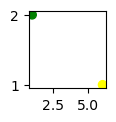

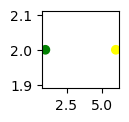

In [7]:
# test if the env and diffferents models
rewarder = Rewarder(num_hidden_units = 32, input_dim = 4)
agent = Actor(num_actions = 4, num_hidden_units = 32, input_dim = 4)

env = GridWorld()
print('State:', env.state)
display_state(env.state)

action_proba = agent(torch.Tensor(env.state).reshape(1,4))
action_index = torch.argmax(action_proba)
reward, playing = env.step(action_index)
print('Reward:',reward)
print('State:', env.state)
display_state(env.state)

In [9]:
# one complete episode
def step_episode(env, model_agent):
    env.reset()
    actions_proba_list = []
    rewards = []
    states = []
    actions = []
    playing = True
    
    while playing == True:
        observation = torch.Tensor(env.state).reshape(1,4)
        
        # run model
        action_proba = model_agent(observation)
        action_index = torch.argmax(action_proba)
        reward, playing = env.step(action_index)
        
        
        # save the data
        states.append(observation)
        actions_proba_list.append(action_proba)
        actions.append(action_index)
        rewards.append(reward)
        
    return  states, actions_proba_list, actions, rewards

In [10]:
# test step episode
rewarder = Rewarder(num_hidden_units = 64, input_dim = 4)
agent = Actor(num_actions = 4, num_hidden_units = 64, input_dim = 4)

env = GridWorld()
states, actions_proba_list, actions, rewards = step_episode(env,agent)

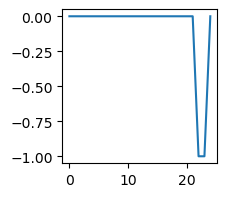

In [11]:
# check if the reward are constant or not
fig = plt.figure(figsize=(2, 2))
plt.plot(rewards)
plt.show()

In [21]:
# display the comparaison for the human preference 
def compare(transition_idx, mystates, actions):
    states = 0
    d1xs = [mystates[transition_idx[0]][0][0], mystates[transition_idx[0]][0][2]]
    d1ys = [mystates[transition_idx[0]][0][1], mystates[transition_idx[0]][0][3]]
    d2xs = [mystates[transition_idx[1]][0][0], mystates[transition_idx[1]][0][2]]
    d2ys = [mystates[transition_idx[1]][0][1], mystates[transition_idx[1]][0][3]]

    fig, ax = plt.subplots(1,2, figsize=(4, 2))
    colors = ['yellow','green']
    color_indices = [0, 1, ]
    colormap = matplotlib.colors.ListedColormap(colors)
    ax[0].scatter(d1xs, d1ys, c=color_indices, cmap=colormap)
    ax[0].set_title(str(decode_action(actions[transition_idx[0]].numpy())))
    ax[1].scatter(d2xs, d2ys, c=color_indices, cmap=colormap)
    ax[1].set_title(str(decode_action(actions[transition_idx[1]].numpy())))
    plt.show()

In [12]:
# Define the loss function
def preference_loss(reward_1, reward_2, dist):
    p1 = torch.exp(reward_1) / (torch.exp(reward_1) + torch.exp(reward_2))
    p2 = torch.exp(reward_2) / (torch.exp(reward_1) + torch.exp(reward_2))
    loss = - (p1*dist[0] + p2*dist[1])
    return loss

In [18]:
# function for asking the preference at the human at the end of an episode
def preference_update( states, actions, rewarder):
    transition_idx = random.sample(range(len(states)),2)
    #transition_samples = [states[transition_idx[0]], states[transition_idx[1]]]

    compare(transition_idx, states, actions)
    pref = input (' select preference a:left, d:right, s:same ')
    if pref == 'a':
        dist = [ 1, 0 ]
    if pref == 'd':
        dist = [ 0, 1 ]
    if pref == 's':
        dist = [ 1, 1 ]
        
    # stuff gradient
    reward_1 = rewarder(states[transition_idx[0]][0])
    reward_2 = rewarder(states[transition_idx[1]][0])
    loss = preference_loss(reward_1, reward_2, dist)
    # rewarder.rewarder_net.zero_grad()
    print('rewards', reward_1, reward_2)
    print(loss)
    optimizer_rewarder.zero_grad()
    loss.backward()
    optimizer_rewarder.step()   

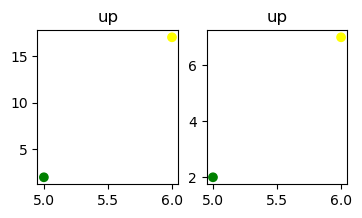

 select preference a:left, d:right, s:same d
rewards tensor([-0.5984], grad_fn=<AddBackward0>) tensor([0.0556], grad_fn=<AddBackward0>)
tensor([-0.6579], grad_fn=<NegBackward0>)


In [19]:
# test one episode with preference asking
preference_update(states, actions, rewarder)

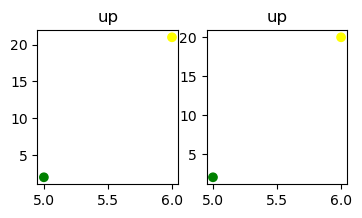

 select preference a:left, d:right, s:same s
rewards tensor([-0.9123], grad_fn=<AddBackward0>) tensor([-0.8311], grad_fn=<AddBackward0>)
tensor([-1.], grad_fn=<NegBackward0>)


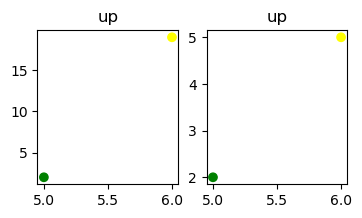

 select preference a:left, d:right, s:same d
rewards tensor([-0.7515], grad_fn=<AddBackward0>) tensor([0.1198], grad_fn=<AddBackward0>)
tensor([-0.7050], grad_fn=<NegBackward0>)


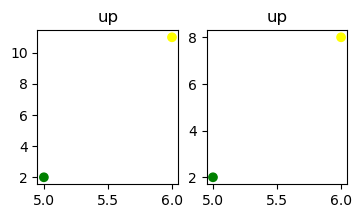

 select preference a:left, d:right, s:same d
rewards tensor([-0.1439], grad_fn=<AddBackward0>) tensor([0.0175], grad_fn=<AddBackward0>)
tensor([-0.5403], grad_fn=<NegBackward0>)


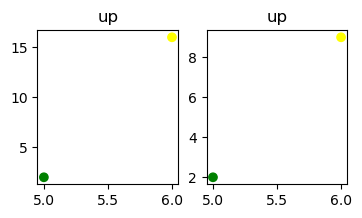

 select preference a:left, d:right, s:same d
rewards tensor([-0.5164], grad_fn=<AddBackward0>) tensor([-0.0352], grad_fn=<AddBackward0>)
tensor([-0.6180], grad_fn=<NegBackward0>)


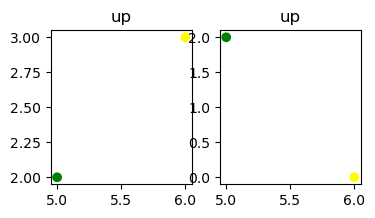

 select preference a:left, d:right, s:same d
rewards tensor([0.1867], grad_fn=<AddBackward0>) tensor([0.2854], grad_fn=<AddBackward0>)
tensor([-0.5247], grad_fn=<NegBackward0>)


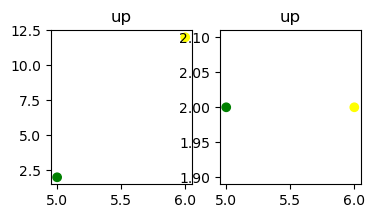

 select preference a:left, d:right, s:same d
rewards tensor([-0.2086], grad_fn=<AddBackward0>) tensor([0.2268], grad_fn=<AddBackward0>)
tensor([-0.6072], grad_fn=<NegBackward0>)


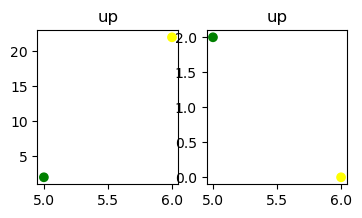

 select preference a:left, d:right, s:same d
rewards tensor([-0.9935], grad_fn=<AddBackward0>) tensor([0.2854], grad_fn=<AddBackward0>)
tensor([-0.7823], grad_fn=<NegBackward0>)


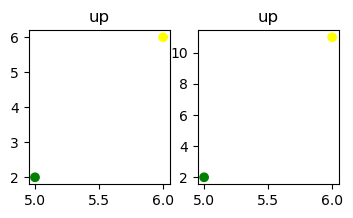

 select preference a:left, d:right, s:same a
rewards tensor([0.0877], grad_fn=<AddBackward0>) tensor([-0.1439], grad_fn=<AddBackward0>)
tensor([-0.5576], grad_fn=<NegBackward0>)


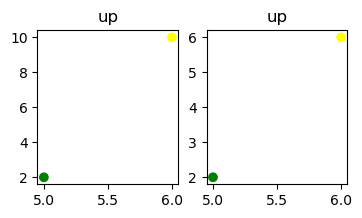

 select preference a:left, d:right, s:same d
rewards tensor([-0.0880], grad_fn=<AddBackward0>) tensor([0.0877], grad_fn=<AddBackward0>)
tensor([-0.5438], grad_fn=<NegBackward0>)


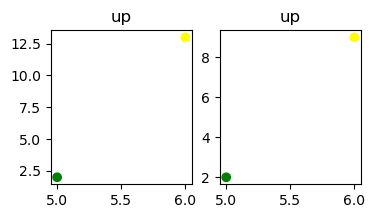

 select preference a:left, d:right, s:same d
rewards tensor([-0.2792], grad_fn=<AddBackward0>) tensor([-0.0352], grad_fn=<AddBackward0>)
tensor([-0.5607], grad_fn=<NegBackward0>)


In [20]:
episodes = 10
for episode in range(episodes):
    preference_update(states, actions, rewarder)